# CS492 Deep Reinforcement Learning - Programming Assignment 1



## Submission Guideline

**How to submit**
*   Fill out <mark> TODO</mark> blocks, **DO NOT** modify other parts of the skeleton code.
*   Submit one file: hw1_{student_ID}.ipynb to KLMS

    e.g. hw1_20221234.ipynb

**Note**
*   You are required to use numpy, do not use neither pytorch nor tensorflow.
*   Check whether your whole cells work well by restarting runtime code and running all before the submission.
*   TA will look into the implemented functions, their validity and give corresponding score to each <mark> TODO</mark> problem.
*   Ask questions through KLMS so that you can share information with other students.
*   TA in charge: Junmo Cho (junmokane@kaist.ac.kr)

**In this programming assignment, you will**
* Learn how to use `gym` environment for reinforcement learning framework
* Implement basic dynamic programming algorithms

## 1. Gym Tutorial

### 1.1. What is Gym?
Gym is a project that provides an API for reinforcement learning environments that include implementations of common environments: cartpole, pendulum, mountain-car, mujoco, atari, and more. The details of gym package can be checked [here](https://www.gymlibrary.dev/content/basic_usage/). 

The API contains four key functions: `make`, `reset`, `step` and `render` that this basic usage will introduce you to. At the core of Gym is `Env` which is a high level python class representing a markov decision process from reinforcement learning theory.

### 1.2. Initializing and Interacting with Environments
The following is the basic preparation for installing gym and importing required packages.

In [270]:
!pip install gym[toy_text]
import numpy as np
import matplotlib.pyplot as plt
import gym
import time

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Initializing environments is very easy in Gym and can be done via the `make` function. Throughout this homework, we will use `FrozenLake` environment.

In [271]:
map_size = 4
is_slippery = False
env = gym.make("FrozenLake-v1", desc=None, map_name=f"{map_size}x{map_size}", is_slippery=is_slippery)

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


The classic **agent-environment loop** pictured below is simplified representation of reinforcement learning that Gym implements.

<img src="https://gymnasium.farama.org/_images/AE_loop_dark.png" width="340" height="260">

This loop is implemented using the following gym code.

In [272]:
observation = env.reset()  # start new episode  

for _ in range(10):

  action = env.action_space.sample()  # sample random action from env 
  print(action)
  observation, reward, terminated, info = env.step(action)  # next state  
  print(observation, reward, terminated, info)

  if terminated:  # if the episode is over
    observation = env.reset()

env.close()

1
4 0.0 False {'prob': 1.0}
2
5 0.0 True {'prob': 1.0, 'TimeLimit.truncated': False}
2
1 0.0 False {'prob': 1.0}
3
1 0.0 False {'prob': 1.0}
2
2 0.0 False {'prob': 1.0}
0
1 0.0 False {'prob': 1.0}
0
0 0.0 False {'prob': 1.0}
1
4 0.0 False {'prob': 1.0}
1
8 0.0 False {'prob': 1.0}
1
12 0.0 True {'prob': 1.0, 'TimeLimit.truncated': False}


After initializing the environment, we `reset` the environment to get the first observation of the environment. 

Next, the agent performs an action in the environment, `step`, this can be imagined as moving a agent or pressing a button on a games’ controller that causes a change within the environment. As a result, the agent receives a new observation from the updated environment along with a reward for taking the action. This reward could be for instance positive for reaching to goal or a negative reward for moving into lava. One such action-observation exchange is referred to as a timestep.

However, after some timesteps, the environment may end, this is called the terminal state. For instance, the robot may have crashed, or the agent have succeeded in completing a task, the environment will need to stop as the agent cannot continue. In gym, if the environment has terminated, this is returned by `step`. If terminated is true then reset should be called next to restart the environment.

### 1.3. FrozenLake Investigation

Throughout this HW, we are going to use `FronzenLake` environment. The goal of the agent in `FrozenLake` is **to navigate from the starting state (S) to the goal state (G) by walking only on frozen tiles (F) and avoid holes (H)**.

We can have two sizes of environment:
- `map_name="4x4"`: a 4x4 grid version
- `map_name="8x8"`: a 8x8 grid version


The environment has two modes:
- `is_slippery=False`: The agent always move in the intended direction due to the non-slippery nature of the frozen lake.
- `is_slippery=True`: The agent may not always move in the intended direction due to the slippery nature of the frozen lake (stochastic).

The below is the visualization of `FrozenLake` environment. You can find more details of environment [here](https://www.gymlibrary.dev/environments/toy_text/frozen_lake/).

![alt text](https://gymnasium.farama.org/_images/frozen_lake.gif)

Now let's check environment variables in `FrozenLake`.

In [273]:
env.reset()  # start a new episode

obs_sample = env.observation_space.sample()
act_sample = env.action_space.sample()

print("Observation Space: ", env.observation_space)
print("Observation Sample: ", obs_sample)  # Sample a random observation
print("Action Space Dimension: ", env.action_space.n)
print("Action Sample: ", act_sample)  # Sample a random action
tr = env.P[obs_sample][act_sample]  # Transition probability
print("Transition:", tr)  # prob, next_state, reward, done

Observation Space:  Discrete(16)
Observation Sample:  13
Action Space Dimension:  4
Action Sample:  1
Transition: [(1.0, 13, 0.0, False)]


We see with `Observation Space Shape Discrete(16)` that the observation is a value representing the **agent’s current position as current_row * nrows + current_col (where both the row and col start at 0)**. 

For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15. The number of possible observations is dependent on the size of the map. **For example, the 4x4 map has 16 possible observations.**

The action space (the set of possible actions the agent can take) is discrete with 4 actions available 🎮:
- 0: GO LEFT
- 1: GO DOWN
- 2: GO RIGHT
- 3: GO UP

Reward function 💰:
- Reach goal: +1
- Reach hole: 0
- Reach frozen: 0

`env.P[o][a]` gives list of transitions that can happen when doing action `a` at state `o`. Note that next state may not be deterministic (This will be important when we deal with `slippery FronzenLake`.  

## 2. Dynamic Programming

### 2.1. Policy Evaluation

Now, let's start implementing basic algorithms in Dynamic Programming! The first algorithm is ***policy evaluation***. If the environment's dynamics is completely known, we can calculate the value function using Bellman equation. Bellman equation for policy evaluation is as follows:
$$v_{k+1}(s)=E_{\pi}[R_{t+1}+\gamma v_{k}(S_{t+1})|S_t=s] \\
=\sum_{a} \pi(a|s) \sum_{s',r} p(s',r|s,a) [r+\gamma v_{k}(s')] 
$$
For more detailed algorithm, refer to figure 4.1 of textbook.

We will start from the random policy for policy evaluation and improve it later. First, let's implement policy that selects actions following uniform distribution.

<mark>TODO-1</mark> Implement the random policy (discrete uniform).

In [274]:
######## TODO ########
# (hint) policy: numpy array with size [s,a], each element represents probability of action given state
random_policy = np.full((16,4), 0.25)
print(random_policy.shape)
######################

(16, 4)


To monitor how each DP algorithms run for each iterations, we want to visualize the value function with heatmap so that we can easily see how value changes when the policy changes (or update is done).

<mark>TODO-2</mark> Implement the visualization of value table with heatmap.

In [275]:
def visualize_value_table(value, map_size):
    """
    Visualze value function for FrozenLake environment
    
    Args:
        value: numpy array with size [s,], value table
        map_size: int, FrozenLake map size
    Returns:
        None
    """
    ######## TODO ########
    # (hint) reshape value and use plt.matshow()
    value = value.reshape((map_size, map_size))
    plt.matshow(value)
    ######################
    plt.clim(0, 1)  
    plt.colorbar()
    plt.show()
    plt.close()

<mark>TODO-3</mark> Implement the policy evaluation function.

In [276]:
def policy_evaluation(policy, env, discount_factor=0.9, theta=0.00001, map_size=4):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: numpy array with size [s,a], each element represents probability of action given state
        env: gym environment
        discount_factor: float, gamma discount factor
        theta: float, stopping criteria
        map_size: int, FrozenLake map size
    Returns:
        V_new: numpy array with size [s,]
    """
    V_pre, V_new = None, None
    ######## TODO ######## 
    # 0: GO LEFT
    # 1: GO DOWN
    # 2: GO RIGHT
    # 3: GO UP
    # env.P[obs_sample][act_sample]
    # prob, next_state, reward, done
    #   action = env.action_space.sample()  # sample random action from env 
    #   print(action)
    #   observation, reward, terminated, info = env.step(action)  # next state  
    # print(observation, reward, terminated, info)
    # if terminated:  # if the episode is over
    #   observation = env.reset()

    V_pre, V_new = np.zeros(policy.shape[0]), np.zeros(policy.shape[0])
    count =0
    while (not np.all(np.abs(V_pre - V_new) < theta)) or count ==0:
      count+=1
      V_pre = np.copy(V_new)
      V_new = np.zeros(policy.shape[0])
      for state_idx in range(V_new.shape[0]):
        for action_idx in range(policy[state_idx].shape[0]):
          possible_results= env.P[state_idx][action_idx]
          for result in possible_results:
            # prob, next_state, reward, done
            # print(state_idx, action_idx)
            # print(result)
            # if(result[3] is False or result[2] == 1):
            V_new[state_idx] += policy[state_idx, action_idx] * result[0]*(result[2] + discount_factor * V_pre[result[1]]) 
      # print(V_pre)
      # print(V_new)
      # print( np.abs(V_pre - V_new) < theta)
      # print(  theta)
    # print("This_is_eval_count: ",count)
    # print(V_new)
    # print(np.all(np.abs(V_pre - V_new) >= theta))
    ######################
    return V_new

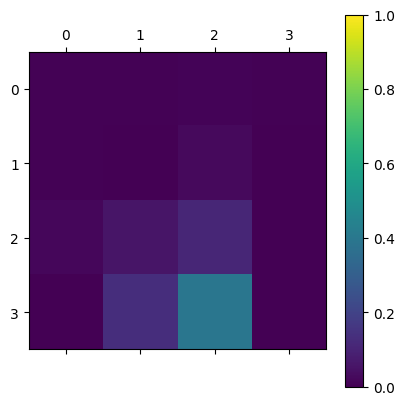

In [277]:
# Check value table
value_table = policy_evaluation(random_policy, env)
value_table_ans = np.array([0.0044593, 0.0042131, 0.01006041, 0.00411379,
                            0.0067141, 0., 0.02633197, 0.,
                            0.01867277, 0.05760567, 0.10697105, 0.,
                            0., 0.13038228, 0.39148958, 0.])
assert np.all(np.abs(value_table - value_table_ans) < 1e-3)
visualize_value_table(value_table, map_size)

### 2.2. Policy Iteration

The reason for computing the value function for a policy is to help find better
policies. Suppose we have determined the value function $v_{\pi}$ for an arbitrary deterministic policy $\pi$. Then, we can have new greedy policy $\pi'$ via policy improvement from following equation.

$$
\pi'(s)= \text{argmax}_{a} \sum_{s',r} p(s',r|s,a) [r+\gamma v_{\pi}(s')] 
$$

Once a policy $\pi$ has been improved using $v_{\pi}$ to yield a better policy $\pi'$, we can then compute $v_{\pi'}$ and improve it again to yield an even better $\pi''$. We can thus obtain a sequence of monotonically improving policies and value functions:

$$
\pi_{0} ⟶^{e} v_{\pi_{0}} ⟶^{i} \pi_{1} ⟶^{e} v_{\pi_{1}} ⟶^{i} \pi_{2} … ⟶^{i} \pi_{*} ⟶^{e} v_{\pi_{*}}
$$

where $⟶^{e}$ denotes policy evaluation and $⟶^{i}$ denotes policy improvement. Each policy is guaranteed to be a strict improvement over the previous one (unless it is already optimal). Because a finite MDP has only a finite number
of policies, this process must converge to an optimal policy and optimal value
function in a finite number of iterations.

This way of finding an optimal policy is called ***policy iteration***. For more detailed algorithm, refer to figure 4.3 of textbook. 

For step-by-step implementation of the algorithm, let's implement a helper function first. 
One step lookahead function calculates action-value as follows.

$$q_{\pi}(s,a)= \sum_{s',r} p(s',r|s,a) [r+\gamma v_{\pi}(s')] 
$$ 

<mark>TODO-4</mark> Implement the one step lookahead function.

In [278]:
def one_step_lookahead(state, V, env, discount_factor):
    """
    Helper function to calculate the value for every action in a given state.
    
    Args:
        state: integer, current state
        V: numpy array with size [s,], value table
        env: gym environment
        discount_factor: float, gamma discount factor
    Returns:
        A: numpy array with size [a,], action value table for state
    """
    A = np.zeros(4)
    ######## TODO ########
    # possible_results= env.P[state_idx][action_idx]
    #       for result in possible_results:
    #         # prob, next_state, reward, done
    #         # print(state_idx, action_idx)
    #         # print(result)
    #         if(result[3] is False or result[2] == 1):
    #           V_new[state_idx] += policy[state_idx, action_idx] * result[0]*(result[2] + discount_factor * V_pre[result[1]]) 
    for action_idx in range(A.shape[0]):
      possible_results= env.P[state][action_idx]
      for result in possible_results:
        A[action_idx] += result[0]*(result[2] + discount_factor * V[result[1]]) 
    ######################
    return A

This time, we will start from **Going Left** policy (initial policy) for policy iteration.

<mark>TODO-5</mark> Implement the **Going Left** policy.

In [279]:
def go_left_policy(env):
    """
    Go Left Policy
    
    Args:
        env: gym environment  
    Returns:
        policy: numpy array with size [s,a], each element represents probability of action given state
    """
    ######## TODO ########
     # prob, next_state, reward, done
    # policy = np.zeros((env.observation_space.n, env.action_space.n))
    # for state in range(env.observation_space.n):
    #   is_done =[]
    #   for action in range(env.action_space.n):
    #     # print
    #     is_done.append(env.P[state][action][0][3])
    #   num_false = len(is_done) - sum(is_done)
    #   if (is_done[0] == False) or (num_false ==0):
    #     policy[state,:] = [1,0,0,0]
    #   else:
    #     policy[state,:] = [int(not val)/num_false for val in is_done]
    policy = np.array([1,0,0,0] *16).reshape(16,4)
    # print(policy)
    ######################
    return policy

To monitor how policy changes for each iterations, we want to visualize the policy in `FrozenLake` so that we can easily see how policy changes based on value function.

<mark>TODO-6</mark> Implement the visualization of greedy policy.

In [280]:
def visualize_greedy_policy(policy, map_size):
    """
    Visualize greedy policy based on policy. For e.g., printed result will be
    
    Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
    [[0 0 0 0]
    [0 0 1 0]
    [0 1 1 0]
    [0 2 2 0]]
    
    Args:
        policy: numpy array with size [s,a], each element represents probability of action given state
        map_size: int, FrozenLake map size
    Returns:
        None
    """
    print("Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):")
    ######## TODO ########
    # print(policy)
    max_indexes = np.argmax(policy, axis=1)

    # 4,4 shape의 결과 array 생성
    result = np.zeros((map_size, map_size), dtype=int)

    # 결과 array의 각 row에 max_indexes 값을 채워넣기
    # print(max_indexes)
    for i, arg in enumerate(max_indexes):
        result[i//4, i%4] = arg

    print(result)
    # print(grid)
    ######################
    return

In [281]:
visualize_greedy_policy(policy, 4)

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[1 2 1 0]
 [1 0 1 0]
 [2 1 1 0]
 [0 2 2 0]]


<mark>TODO-7</mark> Implement the policy iteration.

In [282]:
def policy_iteration(env, init_policy, discount_factor=0.9, map_size=4):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy until an optimal policy is found.
    
    Args:
        env: gym environment  
        init_policy: numpy array with size [s,a], each element represents probability of action given state
        discount_factor: float, gamma discount factor
        map_size: int, FrozenLake map size
    Returns:
        tuple of (policy, V)
        policy: numpy array with size [s,a], each element represents probability of action given state
        V: numpy array with size [s,], value table
    
    (IMPORTANT!): For each iteration, use visualize_value_table, and visualize_greedy_policy function for visualization! 
    """

    policy_prev, policy_next, V = init_policy,init_policy, np.zeros((map_size**2, env.action_space.n))
    ######## TODO ########
    count =0
    while (not np.all(policy_prev == policy_next)) or count==0:
    # while count<2:
      count+=1
      policy_argmax_columns =[]
      policy_prev = np.copy(policy_next)
      policy_next = np.zeros((map_size**2, env.action_space.n))
      # print(policy_prev)
      V = policy_evaluation(policy_prev, env, discount_factor, map_size = map_size)
      # print(V)
      for state_idx in range(V.shape[0]):
        policy_for_individual_state = one_step_lookahead(state_idx, V, env, discount_factor)
        # print(policy_for_individual_state)
        policy_argmax_columns.append(np.argmax(policy_for_individual_state))
      policy_next[np.arange(map_size**2), policy_argmax_columns] =1
      # print(policy_next)
      print(count)
      visualize_value_table(V, map_size)
      visualize_greedy_policy(policy_next, map_size)
    ######################
    return policy_next, V

### 2.3. Value Iteration

One drawback to policy iteration is that each of its iterations involves policy
evaluation, which may itself be a protracted iterative computation requiring
multiple sweeps through the state set.
If policy evaluation is done iteratively, then convergence exactly to $v_{\pi}$ occurs only in the limit. In fact, the policy evaluation step of policy iteration can be truncated in several ways without losing the convergence guarantees of policy iteration.
One important special case is when policy evaluation is stopped after just one
sweep (one backup of each state). 
This algorithm is called ***value iteration***. 
It can be written as a particularly simple backup operation that combines the policy improvement and truncated policy evaluation steps:

$$
v_{k+1}(s)=\text{max}_{a} \textbf{E}[R_{t+1}+\gamma v_{k}(s_{t+1}) | S_t=s, A_t=a] \\
= \text{max}_{a} \sum_{s',r} p(s',r|s,a) [r+\gamma v_{k}(s')] 
$$

for all $s \in S$. For arbitrary $v_0$, the sequence $v_k$ can be shown to converge to $v_{*}$ under the same conditions that guarantee the existence of $v_{*}$. 
Finally, let us consider how value iteration terminates. 
Like policy evaluation, value iteration formally requires an infinite number of iterations to converge exactly to $v_{*}$. 
In practice, we stop once the value function changes by only a small amount in a sweep. For more detailed algorithm, refer to figure 4.5 of textbook. 

**Note that above equation holds when the policy is deterministic.**


<mark>TODO-8</mark> Implement the value iteration.

In [283]:
def value_iteration(env, theta=0.0001, discount_factor=0.9, map_size=4):
    """
    Value Iteration Algorithm.
    
    Args:
        env: gym environment  
        theta: float, stopping criteria
        discount_factor: float, gamma discount factor
        map_size: int, FrozenLake map size
    Returns:
        tuple of (policy, V)
        policy: numpy array with size [s,a], each element represents probability of action given state
        V: numpy array with size [s,], value table
    
    (IMPORTANT!): For each iteration, use visualize_value_table for visualization! 
    """
    policy = np.full((16,4), 0.25)
    V_prev, V_next = np.zeros(map_size**2), np.zeros(map_size**2)
    # policy_prev, policy_next, V = init_policy,init_policy, np.zeros((map_size**2, env.action_space.n))
    ######## TODO ########
    count =0
    policy_argmax_columns=[]
    # while (np.max(np.abs(V_next - V_prev)) > theta ) or count<=10:
    while (np.max(np.abs(V_next - V_prev)) > theta ) or count ==0:
      count+=1
      V_prev = np.copy(V_next)
      V_next = np.zeros(map_size**2)
      for state_idx in range(V_prev.shape[0]):
        max_value = 0
        for action_idx in range(env.action_space.n):
          result = env.P[state_idx][action_idx][0]
          # prob, next_state, reward, done
          possible_value = result[0] * (result[2] + discount_factor * V_prev[result[1]]) 
          if(possible_value > max_value):
            max_value = possible_value
        V_next[state_idx] = max_value
      # print(V_prev)
      # print(V_next)
      # print(np.max(np.abs(V_next - V_prev)) > theta)
      # print(count)
      visualize_value_table(V_next, map_size)
    
    for state_idx in range(V_prev.shape[0]):
      policy_for_individual_state = one_step_lookahead(state_idx, V_next, env, discount_factor)
      # print(policy_for_individual_state)
      policy_argmax_columns.append(np.argmax(policy_for_individual_state))
    policy[np.arange(map_size**2), policy_argmax_columns] =1
    ######################
    return policy, V_next

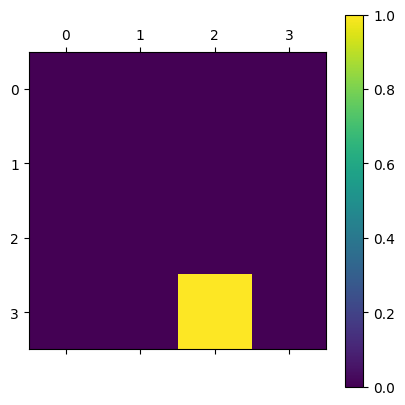

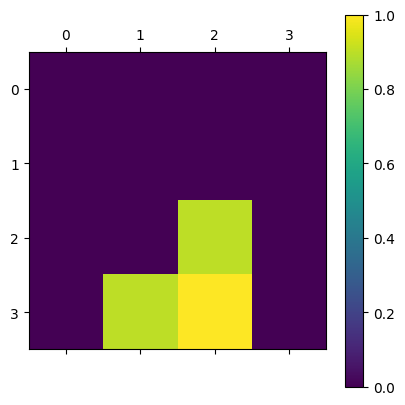

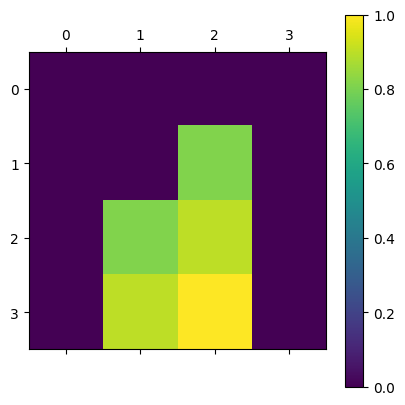

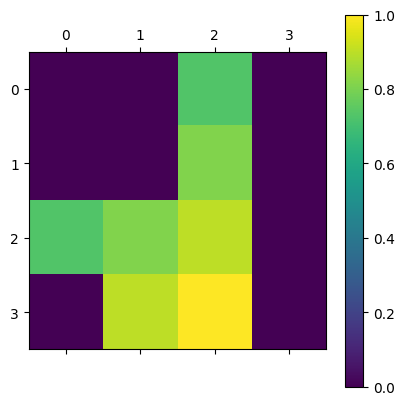

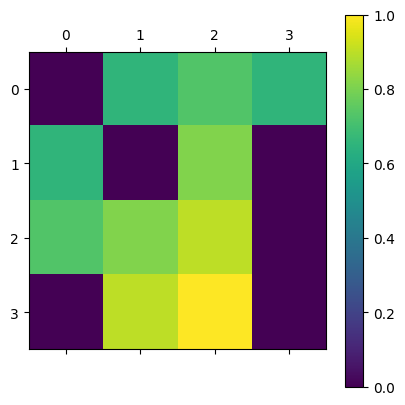

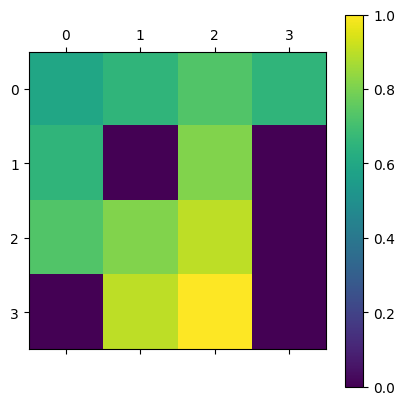

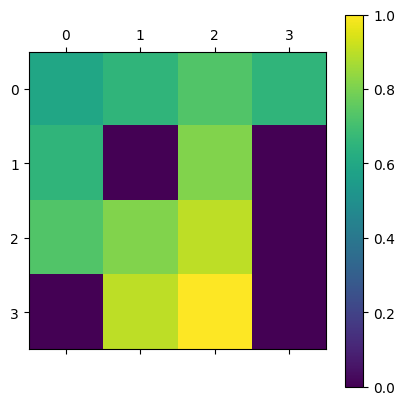

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[1 2 1 0]
 [1 0 1 0]
 [2 1 1 0]
 [0 2 2 0]]


In [284]:
policy, v = value_iteration(env, discount_factor=0.9)
visualize_greedy_policy(policy, map_size)

<mark>TODO-9</mark> Answer the following questions.

*   Try running value_iteration with different `discount_factor` (e.g., 0.1, 0.5), Is there any difference in result when $0<γ<1$? 
*   Try running value_iteration with $γ=1$. Explain the difference.

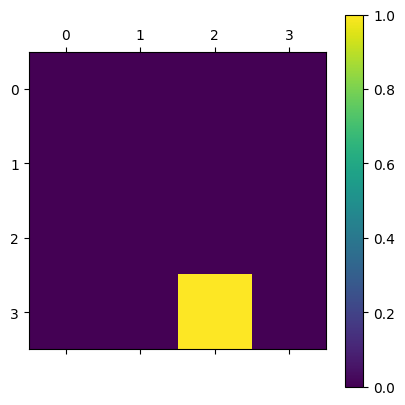

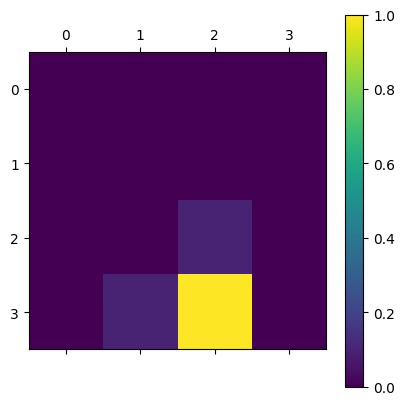

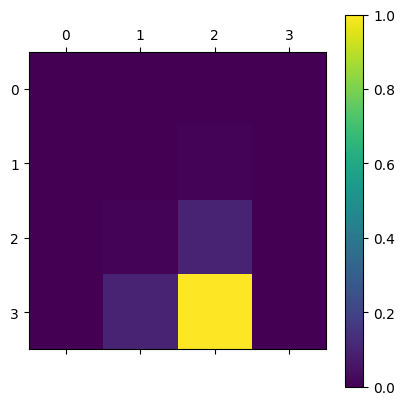

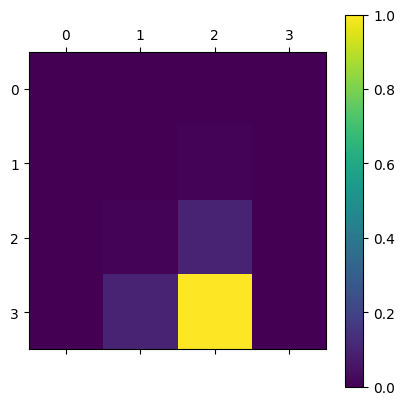

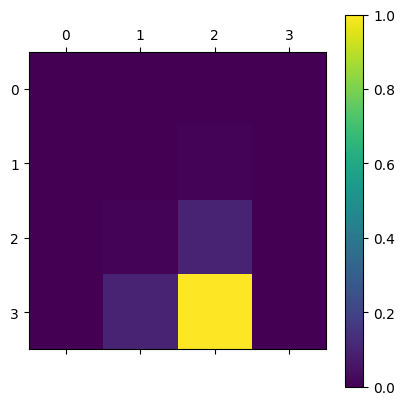

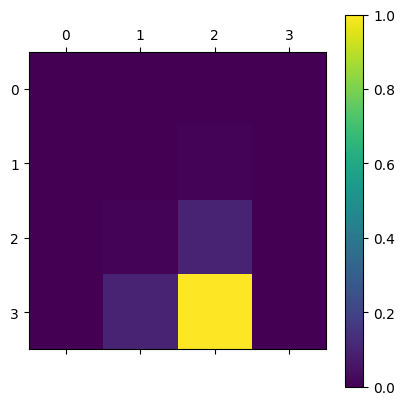

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[1 2 1 0]
 [1 0 1 0]
 [2 1 1 0]
 [0 2 2 0]]


In [285]:
policy,v = value_iteration(env, discount_factor=0.1)
visualize_greedy_policy(policy, map_size)

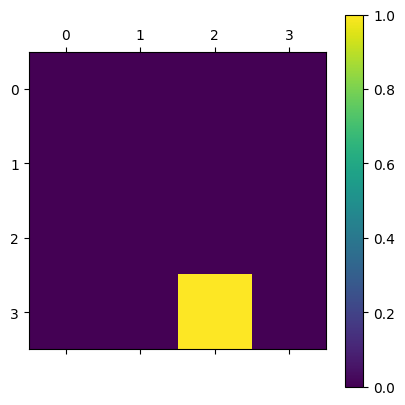

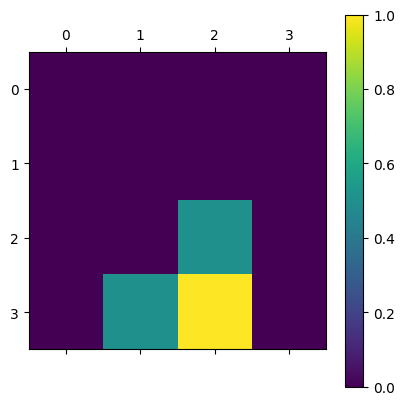

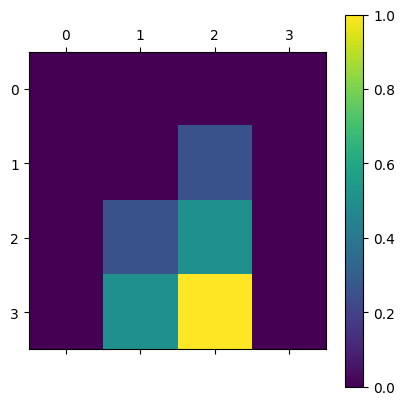

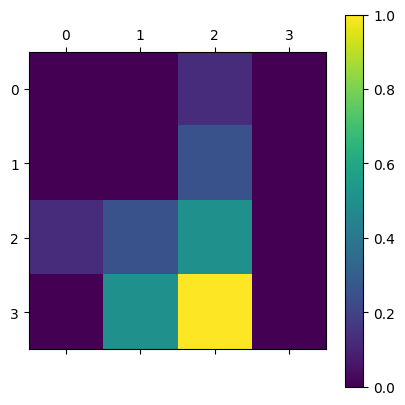

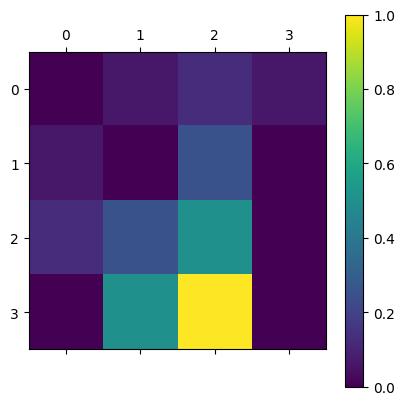

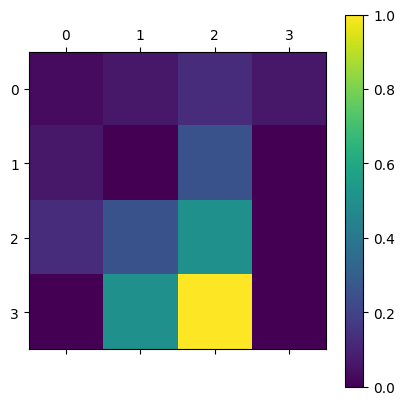

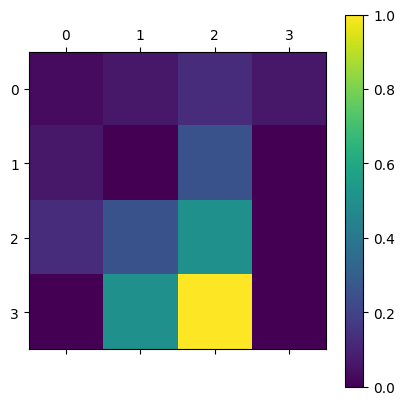

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[1 2 1 0]
 [1 0 1 0]
 [2 1 1 0]
 [0 2 2 0]]


In [286]:
policy,v = value_iteration(env, discount_factor=0.5)
visualize_greedy_policy(policy, map_size)

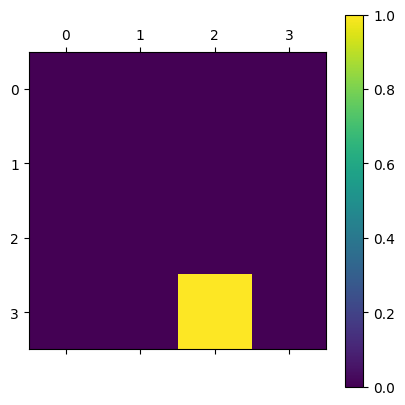

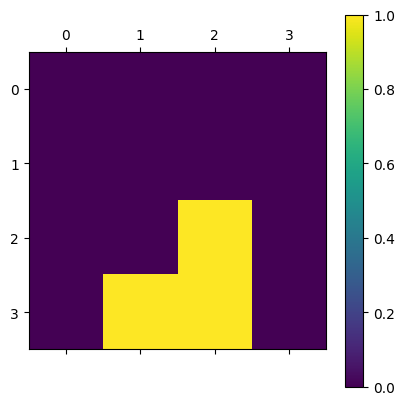

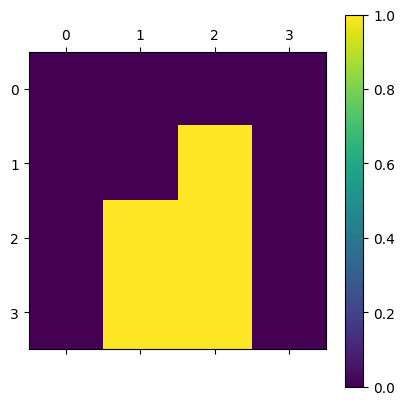

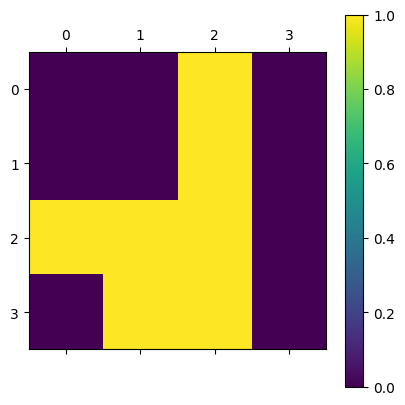

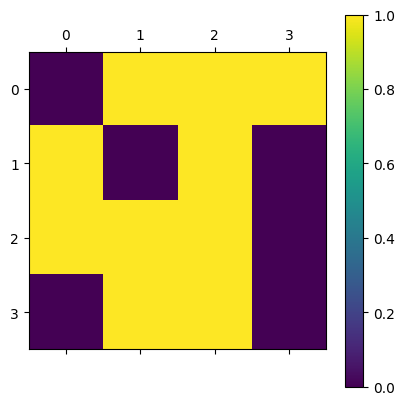

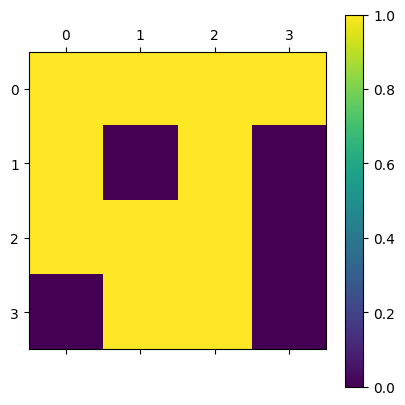

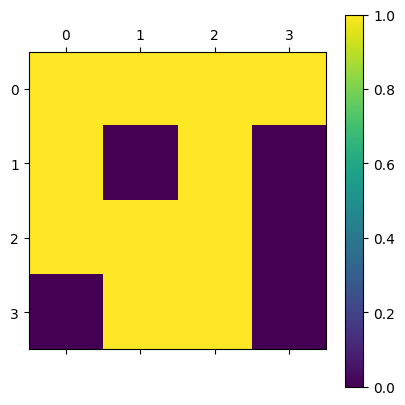

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0 0 0 0]
 [0 0 1 0]
 [0 0 0 0]
 [0 1 0 0]]


In [287]:
policy,v = value_iteration(env, discount_factor=1)
visualize_greedy_policy(policy, map_size)

<mark>Answer for TODO-9</mark>
* There was no difference on policy when 0< γ <1.
* When γ ==1, policy dramatically changed.
 In value update, because now γ ==1, value of all state in the path to the goal is now 1. In this situation, agent does not have incentive to move forward to the goal.

### 2.4. Asynchronous Dynamic Programming (In-place Value Iteration)

A major drawback to the DP methods that we have discussed so far is that
they involve operations over the entire state set of the MDP, that is, they
require sweeps of the state set. 
If the state set is very large, then even a single sweep can be prohibitively expensive.
For example, the game of Go has about $10^{172}$. 
Even if we could perform the value iteration backup on a million states per second, it would take forever to complete a single sweep.

Asynchronous DP algorithms are in-place iterative DP algorithms that are
not organized in terms of systematic sweeps of the state set. 
These algorithms back up the values of states in any order whatsoever, using whatever values of other states happen to be available. 

In this section, we will implement a simple asynchronous DP algorithm, which is in-place value iteration. This version of asynchronous value iteration backs up the value, in place, of only one state, $s_k$, on each step, $k$, using the value iteration backup. 

<mark>TODO-10</mark> Implement the asynchronous value iteration.

In [288]:
def asynchronous_value_iteration(env, theta=0.0001, discount_factor=0.9, map_size=4):
    """
    Asynchronous Value Iteration Algorithm.
    
    Args:
        env: gym environment  
        theta: float, stopping criteria
        discount_factor: float, gamma discount factor
        map_size: int, FrozenLake map size
    Returns:
        tuple of (policy, V)
        policy: numpy array with size [s,a], each element represents probability of action given state
        V: numpy array with size [s,], value table
    
    (IMPORTANT!): For each iteration, use visualize_value_table for visualization! 
    """
    policy = np.full((16,4), 0.25)
    V = np.zeros(map_size**2)
    # policy_prev, policy_next, V = init_policy,init_policy, np.zeros((map_size**2, env.action_space.n))
    ######## TODO ########
    count =0
    policy_argmax_columns=[]
    larger_than_theta = False
    # while (np.max(np.abs(V_next - V_prev)) > theta ) or count<=10:
    while larger_than_theta or count ==0:
      larger_than_theta = False
      count+=1
      for state_idx in range(V.shape[0]):
        max_value = 0
        for action_idx in range(env.action_space.n):
          result = env.P[state_idx][action_idx][0]
          # prob, next_state, reward, done
          possible_value = result[0] * (result[2] + discount_factor * V[result[1]]) 
          if(possible_value > max_value):
            
            # print(abs(possible_value - max_value))
            max_value = possible_value
        if(abs(V[state_idx] - max_value) >theta ):
          larger_than_theta = True
        V[state_idx] = max_value
      # print(V)
      # print(V_prev)
      # print(V)
      # print(np.max(np.abs(V_next - V_prev)) > theta)
      print(count)
      visualize_value_table(V, map_size)
    for state_idx in range(V.shape[0]):
      policy_for_individual_state = one_step_lookahead(state_idx, V, env, discount_factor)
      # print(policy_for_individual_state)
      policy_argmax_columns.append(np.argmax(policy_for_individual_state))
    policy[np.arange(map_size**2), policy_argmax_columns] =1
    ######################
    return policy, V

1


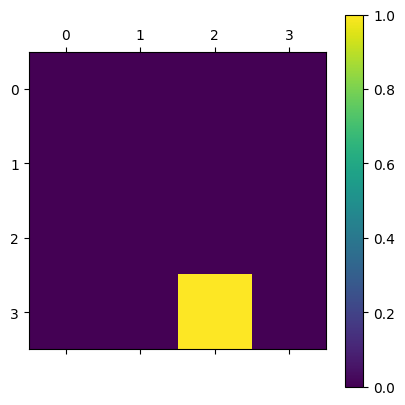

2


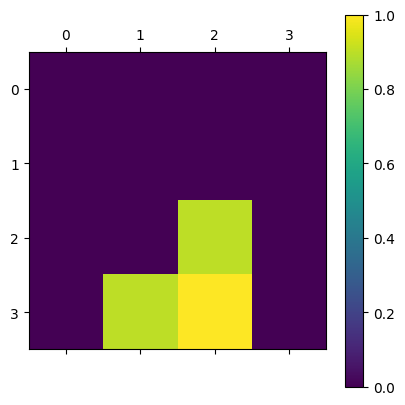

3


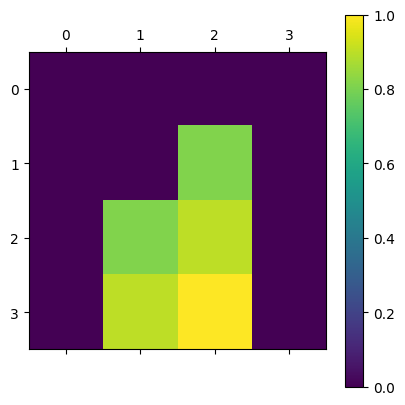

4


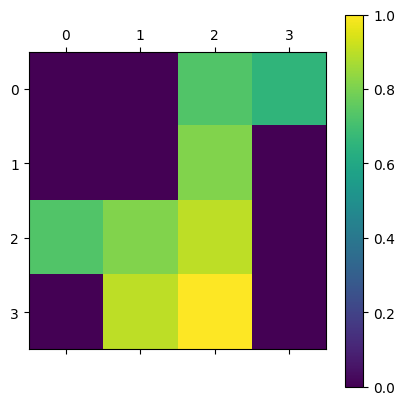

5


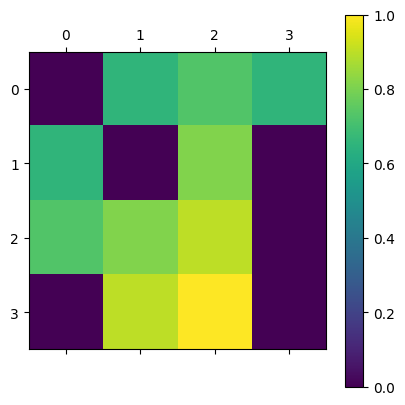

6


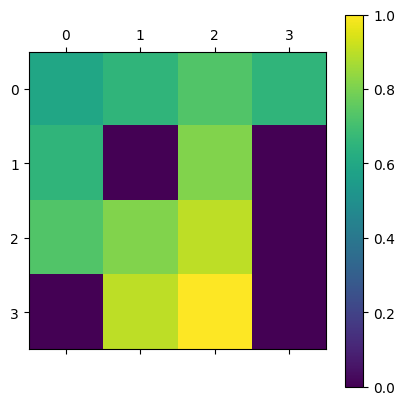

7


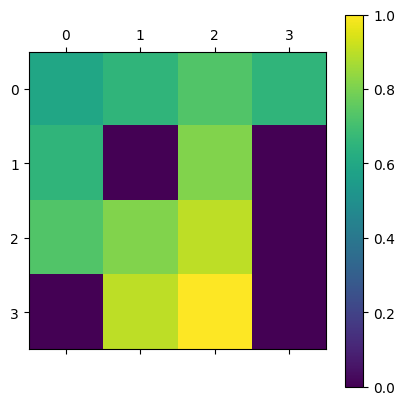

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[1 2 1 0]
 [1 0 1 0]
 [2 1 1 0]
 [0 2 2 0]]


In [289]:
policy, v = asynchronous_value_iteration(env)
visualize_greedy_policy(policy, map_size)

<mark>TODO-11</mark> Answer the following questions.

*   From the results from value iteration and asynchronous value iteration, you can see that convergence speeds (# of iterations) are same. Discuss why this happens and devise how to make asynchoronous value iteration converges faster than value iteration (hint: reverse the loop over state).


<mark>Answer for TODO-11</mark>
*  Because the # of iterations is relatively small(7), convergence speeds are simillar.
* Reversing the loop over state will make asynchronous value iteration converge faster because this helps to update the later states faster. Original value iteration updates the earlier states based on not-updated later states. Therefore reversing the loop over state(update the later states first) will make the states more precise and helps to converge faster.

## 3. More Investigations on FrozenLake

We want to explore more on `FrozenLake` environment. We now consider the case `is_slippery=True`, where the agent will move in intended direction with probability of $1/3$ else will move in either perpendicular direction with equal probability of $1/3$ in both directions.

For example, if action is GO LEFT and `is_slippery=True`, then:
- $P(\text{move left})=1/3$
- $P(\text{move up})=1/3$
- $P(\text{move down})=1/3$

Now, let's make new environment and do policy iteration!

In [290]:
map_size = 4
is_slippery = True
env = gym.make("FrozenLake-v1", desc=None, map_name=f"{map_size}x{map_size}", is_slippery=is_slippery)

1


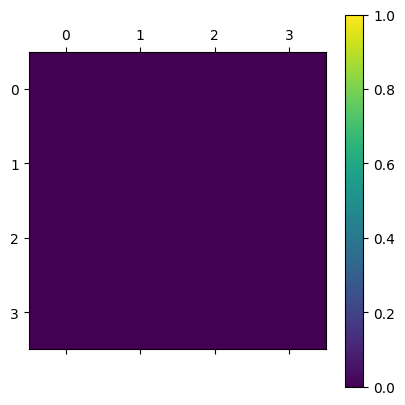

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 1 0]]
2


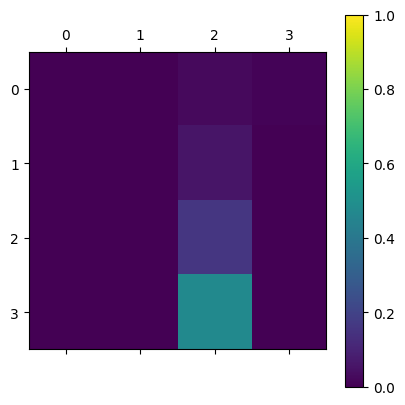

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0 1 2 3]
 [0 0 0 0]
 [0 1 0 0]
 [0 1 2 0]]
3


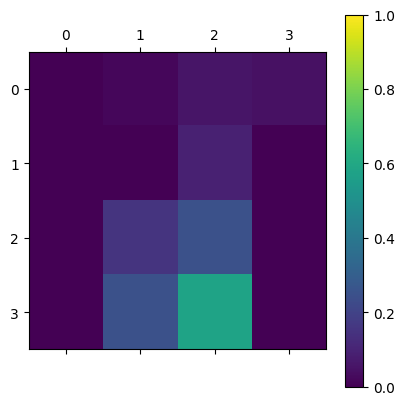

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[1 2 2 3]
 [0 0 0 0]
 [1 1 0 0]
 [0 2 1 0]]
4


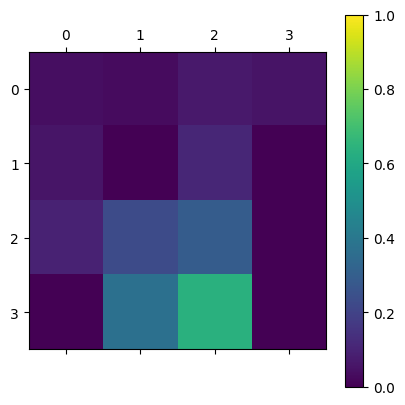

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0 3 2 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]
5


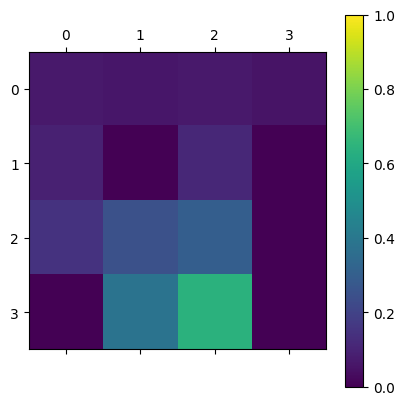

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0 3 0 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]
6


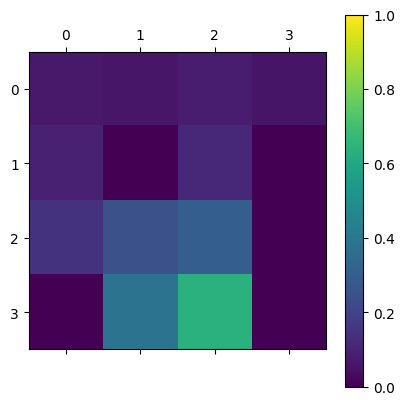

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0 3 0 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]
Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0 3 0 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


In [291]:
policy, v = policy_iteration(env, go_left_policy(env))
visualize_greedy_policy(policy, map_size =4)

In [292]:
map_size = 4
is_slippery = False
env = gym.make("FrozenLake-v1", desc=None, map_name=f"{map_size}x{map_size}", is_slippery=is_slippery)

1


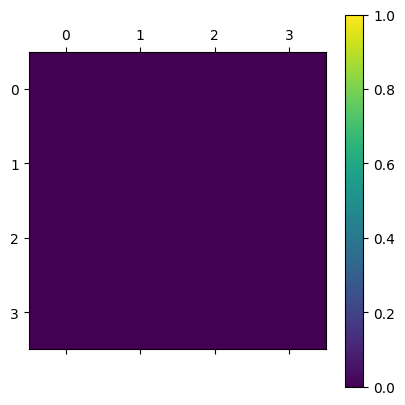

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 2 0]]
2


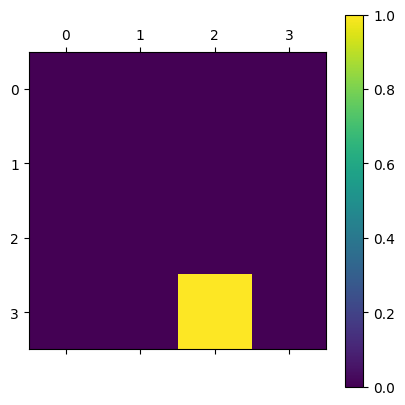

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0 0 0 0]
 [0 0 0 0]
 [0 0 1 0]
 [0 2 2 0]]
3


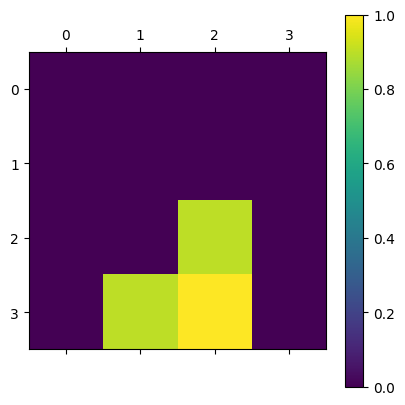

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0 0 0 0]
 [0 0 1 0]
 [0 1 1 0]
 [0 2 2 0]]
4


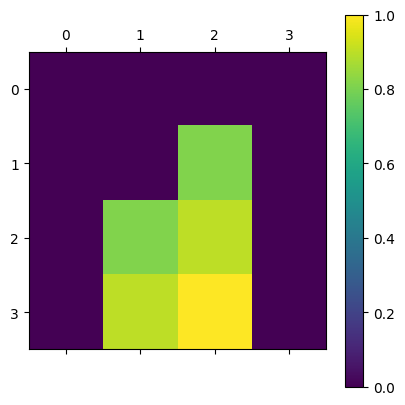

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0 0 1 0]
 [0 0 1 0]
 [2 1 1 0]
 [0 2 2 0]]
5


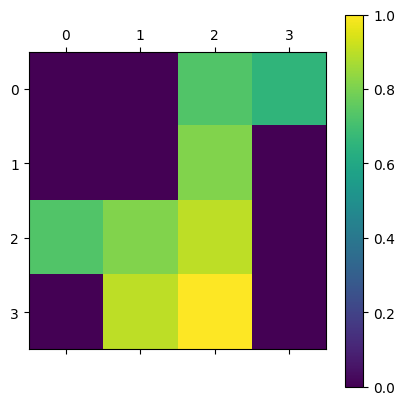

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[0 2 1 0]
 [1 0 1 0]
 [2 1 1 0]
 [0 2 2 0]]
6


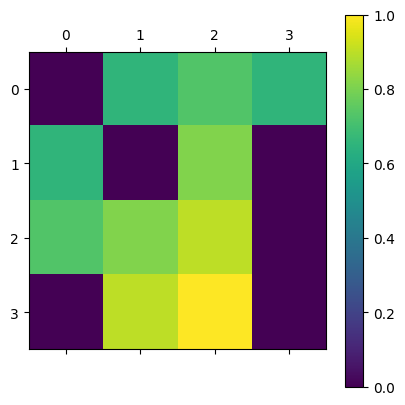

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[1 2 1 0]
 [1 0 1 0]
 [2 1 1 0]
 [0 2 2 0]]
7


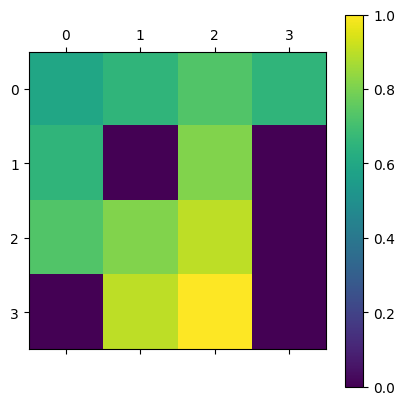

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[1 2 1 0]
 [1 0 1 0]
 [2 1 1 0]
 [0 2 2 0]]
Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[1 2 1 0]
 [1 0 1 0]
 [2 1 1 0]
 [0 2 2 0]]


In [293]:
policy, v = policy_iteration(env, go_left_policy(env))
visualize_greedy_policy(policy, map_size =4)

<mark>TODO-12</mark> Answer the following questions.

*   Explain the difference between optimal policy in `slippery FrozenLake` and `FrozenLake`.

<mark>Answer for TODO-12</mark>
*  In slippery FrozenLake, the agent should consider the randomness after choosing the action. Therefore, optimal policy in FrozenLake is not an optimal policy in slippery FrozenLake. So, optimal policy in slippery FrozenLake is less precise than it in FrozenLake